<a href="https://colab.research.google.com/github/Bharatj001/Sentiment-Analysis-using-NLP-/blob/main/Sentiment_Analysis_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Libraries


In [8]:
# Install the transformers library
!pip install transformers -q

In [9]:
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style('whitegrid')

UPLOAD DATA SET

In [10]:
# Define the file name
file_path = 'googleplaystore_user_reviews.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/googleplaystore_user_reviews.csv')

# Display the first 5 rows of the DataFrame
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [11]:
# Get a concise summary of the DataFrame
print("DataFrame Information:")
df.info()

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [12]:
# Count the number of missing values in each column
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64


Preprocessing

In [13]:
# Create a new dataframe, dropping rows where 'Translated_Review' or 'Sentiment' is missing.
df_clean = df.dropna(subset=['Translated_Review', 'Sentiment'])

# Let's check the shape of the original and the cleaned dataframes
print("Shape of original dataframe:", df.shape)
print("Shape of dataframe after dropping NA:", df_clean.shape)

# Verify that there are no more missing values in these columns
print("\nMissing values after cleaning:")
print(df_clean[['Translated_Review', 'Sentiment']].isnull().sum())

Shape of original dataframe: (64295, 5)
Shape of dataframe after dropping NA: (37427, 5)

Missing values after cleaning:
Translated_Review    0
Sentiment            0
dtype: int64


In [14]:
# Create a new dataframe with just the columns we need
df_final = df_clean[['Translated_Review', 'Sentiment']].copy()

# Rename the columns for easier access
df_final.rename(columns={'Translated_Review': 'text', 'Sentiment': 'sentiment'}, inplace=True)

# Display the first 5 rows of our new final dataframe
display(df_final.head())

,text,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


Sentiment Distribution:
sentiment
Positive    23998
Negative     8271
Neutral      5158
Name: count, dtype: int64


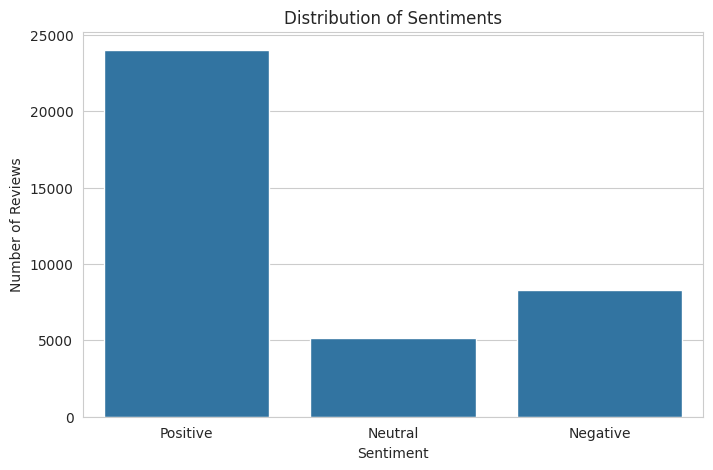

In [15]:
# Check the counts of each sentiment category
print("Sentiment Distribution:")
print(df_final['sentiment'].value_counts())

# Visualize the distribution using a count plot
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df_final, order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [16]:
# Create a dictionary to map sentiment labels to numbers
sentiment_map = {
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2
}

# Apply this mapping to the 'sentiment' column to create a new 'label' column
df_final['label'] = df_final['sentiment'].map(sentiment_map)

# Display the dataframe to confirm the new column has been added correctly
display(df_final.head())

,text,sentiment,label
0,I like eat delicious food. That's I'm cooking ...,Positive,2
1,This help eating healthy exercise regular basis,Positive,2
3,Works great especially going grocery store,Positive,2
4,Best idea us,Positive,2
5,Best way,Positive,2


Tokenization.

In [17]:
from transformers import BertTokenizer

# Define the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
# Take a sample review
sample_text = df_final['text'].iloc[5]
print(f'Original Text: {sample_text}')
print('-' * 20)

# Tokenize the sample text
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,           # Max length to pad/truncate
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',     # Return PyTorch tensors
)

# Print the results
print('Tokens:', tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print('Input IDs:', encoding['input_ids'][0])
print('Attention Mask:', encoding['attention_mask'][0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Keyword arguments {'pad_to_max_length': True} not recognized.


Original Text: Amazing
--------------------
Tokens: ['[CLS]', 'amazing', '[SEP]']
Input IDs: tensor([ 101, 6429,  102])
Attention Mask: tensor([1, 1, 1])


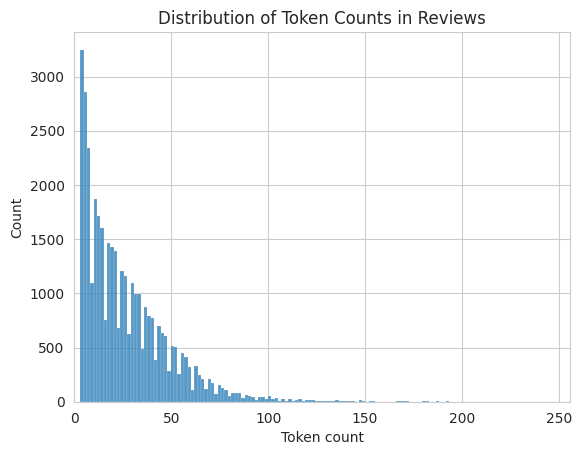

In [19]:
# Tokenize all reviews and get the length of each
token_lens = []
for txt in df_final['text']:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

# Plot the distribution of token lengths
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
plt.title('Distribution of Token Counts in Reviews');

Tokenize Entire Dataset

In [20]:
import torch
from tqdm.notebook import tqdm

# Set the maximum length
MAX_LEN = 160

# Convert the text and label columns to lists
texts = df_final['text'].tolist()
labels = df_final['label'].tolist()

# Tokenize the texts
encoding = tokenizer(
    texts,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

# The tokenizer returns a dictionary-like object. We can access the tensors like this:
input_ids = encoding['input_ids']
attention_masks = encoding['attention_mask']
labels = torch.tensor(labels) # Convert labels to a tensor

# Check the shape of our tensors
print(f'Input IDs Shape: {input_ids.shape}')
print(f'Attention Masks Shape: {attention_masks.shape}')
print(f'Labels Shape: {labels.shape}')

Input IDs Shape: torch.Size([37427, 160])
Attention Masks Shape: torch.Size([37427, 160])
Labels Shape: torch.Size([37427])


Spliting  Data Training and Validation Sets

In [21]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids,
    labels,
    attention_masks,
    random_state=2024,   # A seed for reproducible results
    test_size=0.1,       # 10% of data goes to the validation set
    stratify=labels      # Preserve the same distribution of labels in both sets
)


# Let's check the shapes of our new sets
print("Training Inputs Shape:", train_inputs.shape)
print("Validation Inputs Shape:", validation_inputs.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", validation_labels.shape)
print("Training Masks Shape:", train_masks.shape)
print("Validation Masks Shape:", validation_masks.shape)

Training Inputs Shape: torch.Size([33684, 160])
Validation Inputs Shape: torch.Size([3743, 160])
Training Labels Shape: torch.Size([33684])
Validation Labels Shape: torch.Size([3743])
Training Masks Shape: torch.Size([33684, 160])
Validation Masks Shape: torch.Size([3743, 160])


In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define the batch size
BATCH_SIZE = 16

# Create a TensorDataset for the training data
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)

# Create a DataLoader for the training set.
# We'll use a RandomSampler to select batches randomly.
train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=BATCH_SIZE
        )

# Create a TensorDataset for the validation data
validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)

# Create a DataLoader for the validation set.
# For validation, the order doesn't matter, so we use a SequentialSampler.
validation_dataloader = DataLoader(
            validation_dataset,
            sampler=SequentialSampler(validation_dataset),
            batch_size=BATCH_SIZE
        )

In [23]:
# Get one batch of training data
batch_input_ids, batch_attention_mask, batch_labels = next(iter(train_dataloader))

print(f'Batch of Input IDs has shape: {batch_input_ids.shape}')
print(f'Batch of Attention Masks has shape: {batch_attention_mask.shape}')
print(f'Batch of Labels has shape: {batch_labels.shape}')

Batch of Input IDs has shape: torch.Size([16, 160])
Batch of Attention Masks has shape: torch.Size([16, 160])
Batch of Labels has shape: torch.Size([16])


Build the Model

In [24]:
from transformers import BertForSequenceClassification

# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,      # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3,              # The number of output labels: 3 for our multi-class task.
    output_attentions = False,   # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell PyTorch to run this model on the GPU (if available).
# In Colab, you can enable this under Runtime > Change runtime type > Hardware accelerator > GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f'The model is now loaded on: {device}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model is now loaded on: cuda


In [25]:
from torch.optim import AdamW
from transformers.optimization import get_linear_schedule_with_warmup


# The optimizer is what updates the model's weights to minimize the loss.
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning rate (a common value for fine-tuning BERT)
                  eps = 1e-8 # Adam's epsilon
                )

# We'll train for 3 epochs.
EPOCHS = 3

# The total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS

# Create a learning rate scheduler.
# This will decrease the learning rate linearly from the initial lr set in the optimizer to 0.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value
                                            num_training_steps = total_steps)

In [26]:
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to format time elapsed in hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string in hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Training the Model

In [ ]:
import random
import numpy as np
import time
import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Set the seed for reproducibility.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store the training statistics
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, EPOCHS):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As unpacked here, it consists of three PyTorch tensors:
        # - batch[0]: input ids
        # - batch[1]: attention masks
        # - batch[2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different things depending on what arguments were given.
        # In our case the return value will be below rather than a Tuple because we've given labels.
        # `loss` is the cross entropy loss between the model's logits and the labels.
        # `logits` are the model's output scores for each class.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end, and print the report each epoch.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the step size based on the gradients.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    all_preds = []
    all_labels = []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As unpacked here, it consists of three PyTorch tensors:
        # - batch[0]: input ids
        # - batch[1]: attention masks
        # - batch[2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to compute gradients during our forward pass,
        # since this is just for evaluation.
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is not used here
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and labels for metrics calculation
        all_preds.extend(np.argmax(logits, axis=1).flatten())
        all_labels.extend(label_ids.flatten())


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Report the number of batches
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))


    # Calculate evaluation metrics (accuracy, precision, recall, f1)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')


    print("  Accuracy: {0:.4f}".format(accuracy))
    print("  Precision: {0:.4f}".format(precision))
    print("  Recall: {0:.4f}".format(recall))
    print("  F1 Score: {0:.4f}".format(f1))


    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation took: {:}".format(validation_time))

    # Record the stats for this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


  0%|          | 0/2106 [00:00<?, ?it/s]

  Batch    40  of  2,106.    Elapsed: 0:00:16.
  Batch    80  of  2,106.    Elapsed: 0:00:32.
  Batch   120  of  2,106.    Elapsed: 0:00:48.
  Batch   160  of  2,106.    Elapsed: 0:01:05.
  Batch   200  of  2,106.    Elapsed: 0:01:22.
  Batch   240  of  2,106.    Elapsed: 0:01:39.
  Batch   280  of  2,106.    Elapsed: 0:01:55.
  Batch   320  of  2,106.    Elapsed: 0:02:11.
  Batch   360  of  2,106.    Elapsed: 0:02:28.
  Batch   400  of  2,106.    Elapsed: 0:02:45.
  Batch   440  of  2,106.    Elapsed: 0:03:01.
  Batch   480  of  2,106.    Elapsed: 0:03:18.
  Batch   520  of  2,106.    Elapsed: 0:03:34.
  Batch   560  of  2,106.    Elapsed: 0:03:51.
  Batch   600  of  2,106.    Elapsed: 0:04:07.


In [ ]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A plot of the training and validation loss curves.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_stats, x=df_stats.index, y='Training Loss', label="Training")
sns.lineplot(data=df_stats, x=df_stats.index, y='Valid. Loss', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(df_stats.index)
plt.show()

# A plot of the validation accuracy.
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_stats, x=df_stats.index, y='Valid. Accur.', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(df_stats.index)
plt.show()